In [18]:
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import torch
import torch.nn as nn

np.random.seed(0)

### This file is to check some geometric properties:
- Equation of a plane going through 3 points
- Intersection of a plane with unit square
- Points of intersection between a polygone and a line

In [19]:
x1 = np.array([2,1,3])
x2 = np.array([0,0,1])
x3 = np.array([1,0,1])

basis = np.concatenate(( (x1 - x2).reshape(3,1), (x1 - x3).reshape(3,1)), axis=1)
basis = basis.T

t1 = np.linspace(-2, 2, 100)
t2 = np.linspace(-2, 2, 100)
t1, t2 = np.meshgrid(t1, t2)
plane = t1.reshape(100, 100, 1) * basis[0] + t2.reshape(100, 100, 1) * basis[1]
plane = plane + x1

# Plot the vecros x1, x2 and x3
fig = go.Figure(data=[
    go.Scatter3d(x=[x1[0]], y=[x1[1]], z=[x1[2]], mode='markers', marker=dict(size=5, color='red'), name='x1'),
    go.Scatter3d(x=[x2[0]], y=[x2[1]], z=[x2[2]], mode='markers', marker=dict(size=5, color='blue'), name='x2'),
    go.Scatter3d(x=[x3[0]], y=[x3[1]], z=[x3[2]], mode='markers', marker=dict(size=5, color='green'), name='x3'),
    go.Surface(x=plane[:,:,0], y=plane[:,:,1], z=plane[:,:,2], showscale=False, opacity=1)
])
fig.update_layout(title='Input space partition')
fig.show()

In [20]:
t1 = np.linspace(-0.5, 1, 100)
t2 = np.linspace(-0.5, 1, 100)
t1, t2 = np.meshgrid(t1, t2)
alpha = 1
plane = alpha - t1 - t2

fig = go.Figure(data=[
    go.Surface(x=t1, y=t2, z=plane, showscale=False, opacity=0.5)
])
# Add the unit cube in 3D
fig.add_trace(go.Scatter3d(x=[0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
                           y=[0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0],
                           z=[0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0],
                           mode='lines', line=dict(color='black', width=2)))

# set xlim, ylim, zlim
fig.update_layout(scene=dict(xaxis=dict(range=[-0.5, 1.5]), yaxis=dict(range=[-0.5, 1.5]), zaxis=dict(range=[0, 1.5])))
fig.update_layout(title='Output space partition')
fig.show()

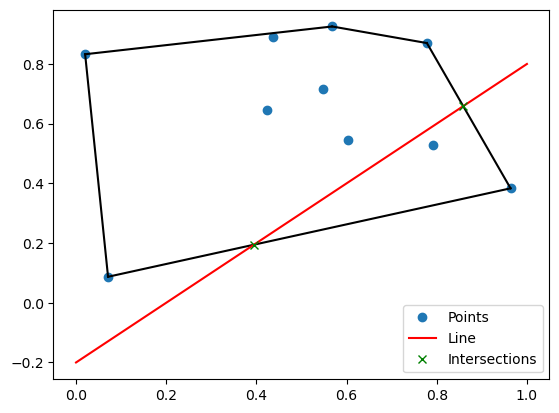

In [21]:
def compute_intersection(p1, p2, a, b, c):
    x1, y1 = p1
    x2, y2 = p2

    denominator = a * (x2 - x1) + b * (y2 - y1)
    if abs(denominator) < 1e-9:  # Parallel line
        return None

    t = -(a * x1 + b * y1 + c) / denominator
    if 0 <= t <= 1:  # Intersection is within the segment
        return (x1 + t * (x2 - x1), y1 + t * (y2 - y1))
    return None

def line_convex_hull_intersection(points, line_coeffs):
    hull = ConvexHull(points)
    edges = hull.simplices
    
    a, b, c = line_coeffs
    intersection_points = []

    # Check intersection with each edge
    for edge in edges:
        p1, p2 = points[edge[0]], points[edge[1]]
        intersection = compute_intersection(p1, p2, a, b, c)
        if intersection is not None:
            intersection_points.append(intersection)
    
    return intersection_points

points = np.random.rand(10, 2)
line_coeffs = (1, -1, -0.2)

intersection_points = line_convex_hull_intersection(points, line_coeffs)

# Plot
hull = ConvexHull(points)
plt.plot(points[:, 0], points[:, 1], 'o', label="Points")
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

x = np.linspace(0, 1, 100)
y = (-line_coeffs[0] * x - line_coeffs[2]) / line_coeffs[1]
plt.plot(x, y, 'r-', label="Line")

intersection_points = np.array(intersection_points)
if len(intersection_points) > 0:
    plt.plot(intersection_points[:, 0], intersection_points[:, 1], 'gx', label="Intersections")

plt.legend()
plt.show()

### Below might be useful at some point, so I keep it here

In [22]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.modules.ModuleList()
        self.layers.append(nn.Linear(2, 4))
        self.layers.append(nn.Linear(4, 4))
        self.layers.append(nn.Linear(4, 4))
        self.layers.append(nn.Linear(4, 1))
        self.relu = nn.ReLU()

    def init_weights(self):
        for l in self.layers:
            torch.nn.init.normal_(l.weight, mean=0.0, std=1.0)
            torch.nn.init.normal_(l.bias)

    def forward(self, x):
        for l in range(len(self.layers)-1):
            x = self.relu(self.layers[l](x))
        x = self.layers[-1](x)
        return x
    
model = MLP()

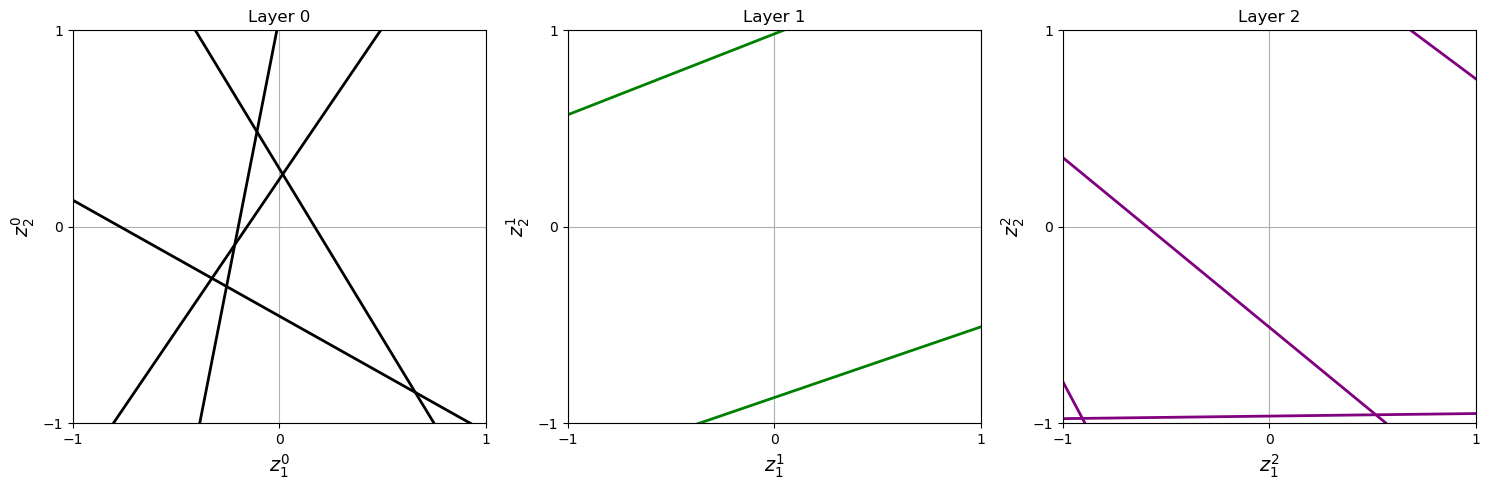

In [23]:
layers = model.layers

colors  = ['black', 'green', 'purple']
fig, axs = plt.subplots(1, len(layers)-1, figsize=(15, 5))

x1 = np.linspace(-1, 1, 100)
z = np.concatenate((x1.reshape(100,1), np.ones((100,1))), axis=1)
for l in range(len(layers)-1):
    W = layers[l].weight.detach().numpy()
    b = layers[l].bias.detach().numpy()
    for i in range(W.shape[0]):
        x2 = -(b[i] + W[i, 0] * x1) / W[i, 1]
        axs[l].plot(x1, x2, color=colors[l], linewidth=2)

for l in range(len(layers)-1):
    axs[l].set_title('Layer %d' % l)
    axs[l].set_xlabel(f'$z^{(l)}_1$', fontsize=14)
    axs[l].set_ylabel(f'$z^{(l)}_2$', fontsize=14) 
    axs[l].set_xlim(-1, 1)
    axs[l].set_ylim(-1, 1)
    axs[l].set_xticks([-1, 0, 1])
    axs[l].set_yticks([-1, 0, 1])
    axs[l].grid() 
plt.tight_layout()